# Load libraries & parameters

In [81]:
%matplotlib inline
import itertools as it
from sklearn.impute import SimpleImputer, KNNImputer
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from keras.utils import np_utils
import seaborn as sns
import scipy.cluster.hierarchy as spc
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.operator import BitFlipMutation, SPXCrossover, BinaryTournamentSelection
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import PrintObjectivesObserver
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, recall_score
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
import datetime
import pickle
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from sklearn import preprocessing
from keras.utils import plot_model

In [32]:
# parameter
n_neighbors = 3
null_percentage = 0.1
test_ratio = 0.2
random_state = 1

load_saved_data = False
load_saved_model = False

# Load dataset

In [3]:
#  reading the data
data_ori = pd.read_csv('uci-secom.csv')
data_ori = data_ori.drop(['Time'], axis = 1)
data_ori.loc[data_ori['Fault'] == 1, 'Fault'] = 1
data_ori.loc[data_ori['Fault'] == -1, 'Fault'] = 0

# getting the shape of the data
print(data_ori.shape)

(1567, 591)


In [4]:
output_labels = data_ori['Fault'].value_counts()
fault_fraction = output_labels[1]/float(output_labels[0])
n_all_data = len(data_ori)
n_pass_data = output_labels[0]
n_fail_data = output_labels[1]
print('fault_fraction', fault_fraction)
print('total data', n_all_data)
print('pass data', n_pass_data)
print('fail data', n_fail_data)

fault_fraction 0.0710868079289132
total data 1567
pass data 1463
fail data 104


In [5]:
data_ori.head()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Fault
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0


In [6]:
data_ori.describe()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Fault
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,0.066369
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.249005
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,0.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,0.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,0.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,0.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


# Preprocessing

## Data cleaning

In [7]:
def drop_constant_column(dataframe):
    for column in dataframe.columns:
        unique = dataframe[column].unique()
        unique = unique[~np.isnan(unique)]
        if len(unique) == 1:
            dataframe.drop(column,inplace=True,axis=1)
    return dataframe

# Drop columns with constant value
data_clean = drop_constant_column(data_ori)

# Only keep columns with NaN values below percentage
data_clean = data_clean.loc[:, data_clean.isnull().mean() < null_percentage]

# print precentage of NaN value in each coloumn
print(data_clean.isnull().mean())

data_clean.head()

0        0.003829
1        0.004467
2        0.008934
3        0.008934
4        0.008934
           ...   
586      0.000638
587      0.000638
588      0.000638
589      0.000638
Fault    0.000000
Length: 423, dtype: float64


,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,Fault
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0


## Data imputation

In [8]:
# data.replace(np.nan, 0, inplace = True)
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = KNNImputer(n_neighbors=n_neighbors)
imputer.fit(data_clean)
data_impu = pd.DataFrame(imputer.transform(data_clean), columns=data_clean.columns)

print("Is there any null?", data_impu.isnull().any().any())

Is there any null? False


## Data normalization

In [9]:
def normalize_data(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(data.values)
    data_norm = pd.DataFrame(x_scaled, columns=data.columns, index=data.index)
    return data_norm

data_norm = normalize_data(data_impu)

In [10]:
if not load_saved_data:
    data_prepro = data_norm
    data_prepro.to_pickle('data_preprocessed.pkl')
else:
    data_prepro = pd.read_pickle('data_preprocessed.pkl')

x_all = data_prepro.iloc[:, :-1]
y_all = data_prepro.iloc[:, -1]

## Data sampling (optional)

In [11]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=1)
x_sample, y_sample = sm.fit_resample(x_all, y_all)
print('Resampled dataset shape %s' % Counter(y_sample))

Resampled dataset shape Counter({0.0: 1463, 1.0: 1463})


## Dataset splitting

In [12]:
data_prepro_sample = pd.concat([x_sample, y_sample], axis=1)

In [13]:
data_prepro_sample['Fault'].value_counts()

1.0    1463
0.0    1463
Name: Fault, dtype: int64

In [14]:
x_train_sample, x_test_sample, y_train_sample, y_test_sample = train_test_split(x_sample, y_sample, test_size=test_ratio, random_state=random_state)

In [99]:
# n_pass_test_set = int(np.ceil(n_all_data*test_ratio)-n_fail_data)

# # split data by class
# pass_set = data_prepro[data_prepro['Fault'] == 0]
# fail_test_set = data_prepro[data_prepro['Fault'] == 1]

# # randomly select and add pass data to become test set
# train_set, pass_test_set = train_test_split(pass_set, test_size = n_pass_test_set, random_state = random_state)
# test_set = pd.concat([fail_test_set, pass_test_set])

# # shuffle test set
# test_set = test_set.reindex(np.random.permutation(test_set.index))

# x_train = train_set.iloc[:, :-1]
# y_train = train_set.iloc[:, -1]
# x_test = test_set.iloc[:, :-1]
# y_test = test_set.iloc[:, -1]

In [100]:
# # Final data
# print('Train set', x_train.shape)
# print(y_train.value_counts())
# print('Test set', x_test.shape)
# print(y_test.value_counts())
# print("Is there any null in x_train?", x_train.isnull().any().any())
# print("Is there any null in y_train?", y_train.isnull().any().any())

# Correlation & Latency aware Feature Selection

## Get correlation coefficient

In [73]:
def correlation_function(corrmat, title):    
    # Get correlations of each features in dataset
    # Range 0-1
    all_correlation = corrmat.values
    feat_to_feat_corr = corrmat.iloc[:-1, :-1]
    feat_to_label_corr = corrmat.iloc[:-1, -1]
    
    # plot only top 100
    fig = feat_to_label_corr.nlargest(100).plot(kind='barh', figsize=(20, 20)).get_figure()
    fig.show()

    if not load_saved_data:
        fig.savefig('feat_to_label_corr_{}.png'.format(title))
        
    #plot heat map
    plt.figure(figsize=(20,20))
    # tick labelnya lompat2 biar muat
    g=sns.heatmap(feat_to_feat_corr, vmin=0, vmax=1,cmap="RdYlGn")

    if not load_saved_data:
        plt.savefig('feat_to_feat_corr_{}.png'.format(title))

C:\Users\HANSUNG\.conda\envs\HAR\lib\site-packages\ipykernel_launcher.py:10: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



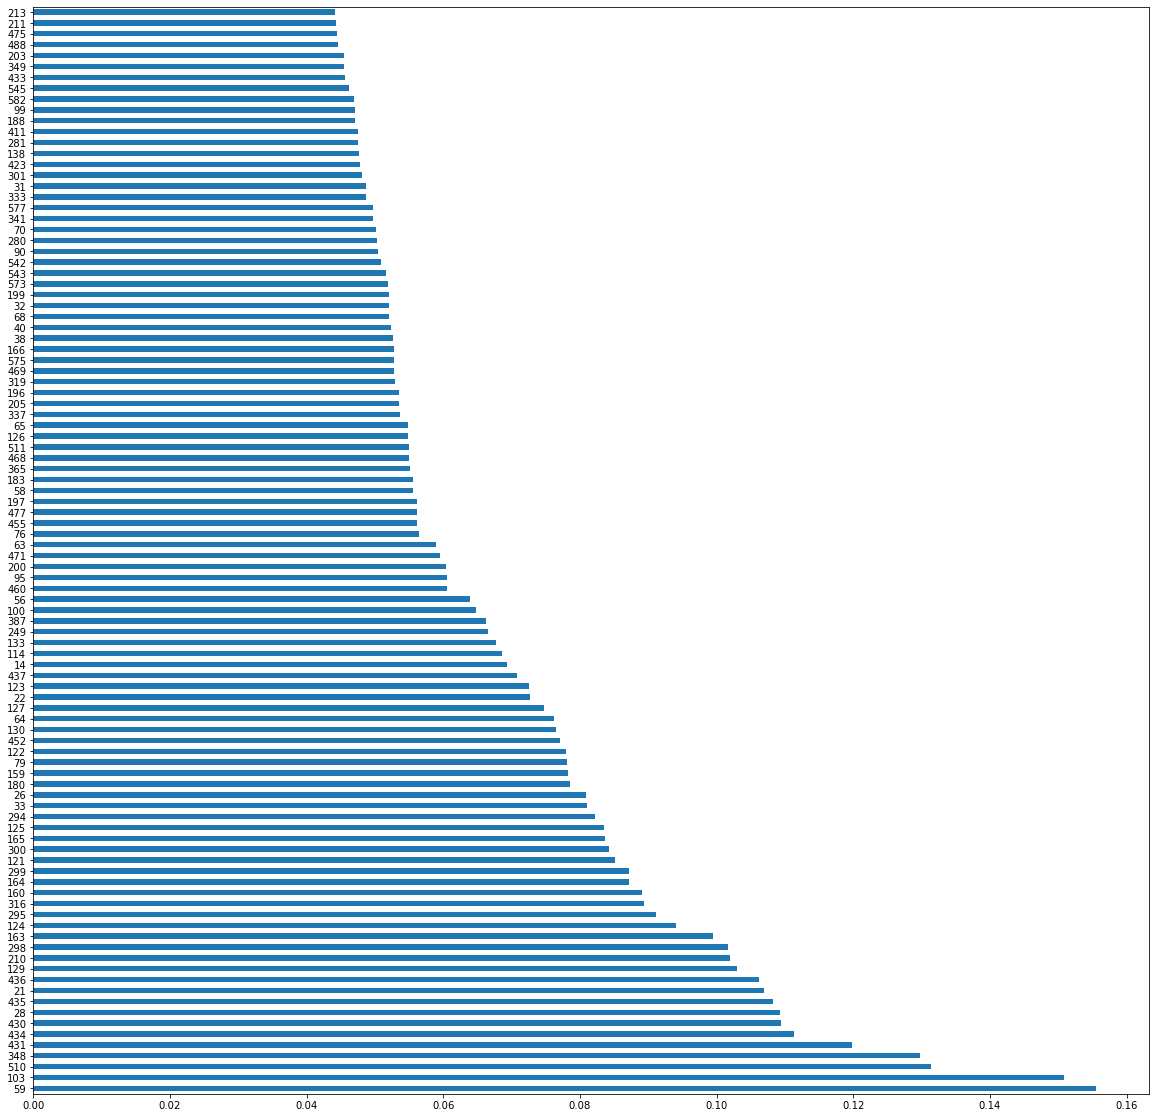

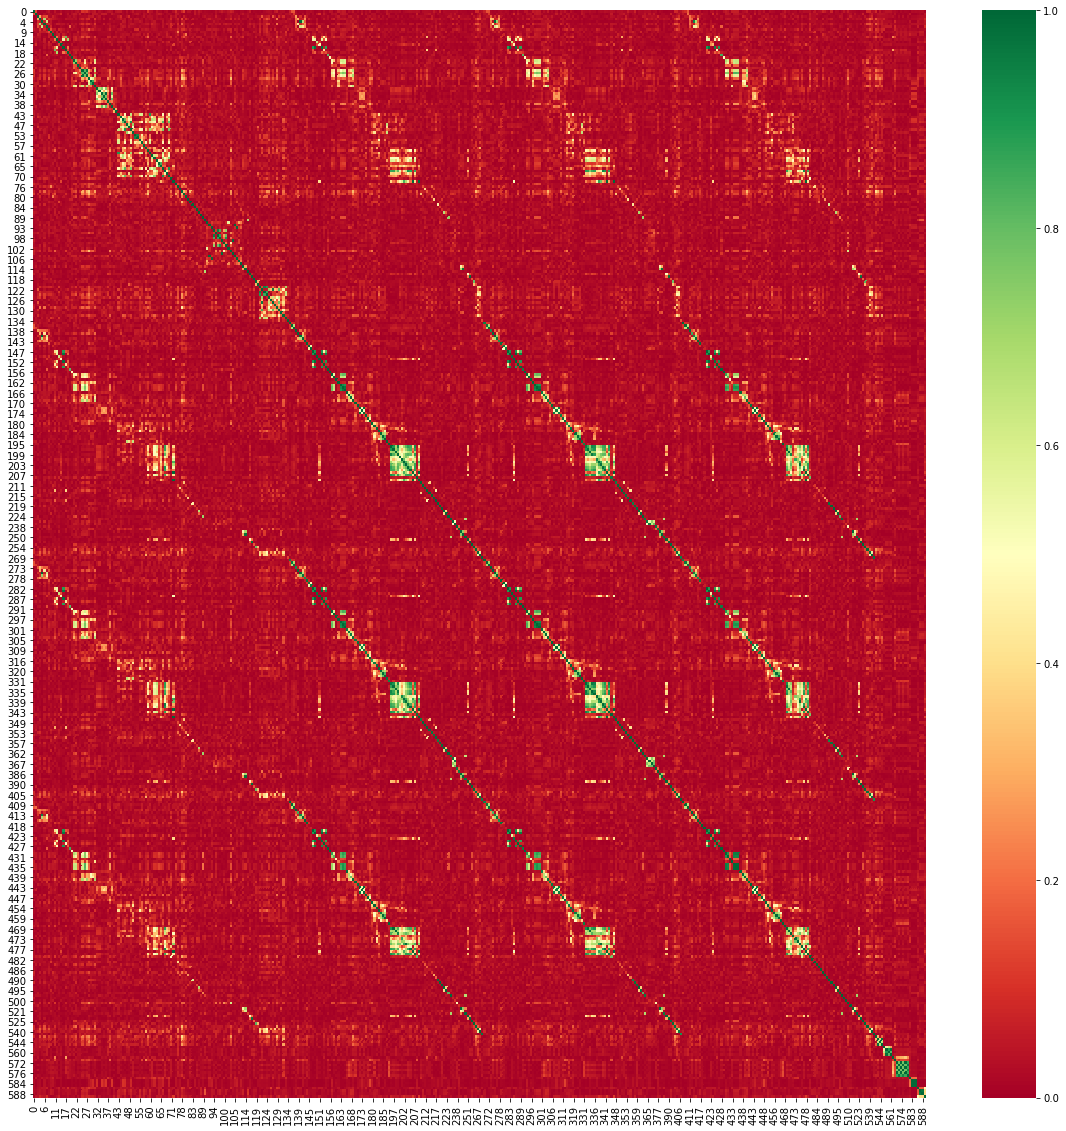

In [75]:
corrmat = abs(data_prepro.corr())
correlation_function(corrmat, 'prepro')

## Get latency scale

In [19]:
# all_latency = np.ones(len(data_prepro.columns))
# all_latency = pd.DataFrame(all_latency.reshape(1, -1), columns=data_prepro.columns)

def load_latency_data(title):
    latency_data = pd.read_csv(title)
    latency_data = latency_data.drop(['Column'], axis = 1)
    return latency_data
    
edge_latency = load_latency_data('edge_latency.csv')
scaled_edge_latency = normalize_data(edge_latency)

cloud_latency = load_latency_data('cloud_latency.csv')
scaled_cloud_latency = normalize_data(cloud_latency)

In [20]:
edge_latency.head()

,Latency
0,6.010
1,2.966
2,5.988
3,8.987
4,6.967


In [21]:
scaled_edge_latency.head()

,Latency
0,0.455727
1,0.179000
2,0.453727
3,0.726364
4,0.542727


## Genetic algorithm

In [22]:
from jmetal.core.problem import BinaryProblem
from jmetal.core.solution import BinarySolution
import random

# Feature correlation selection
class CLFS(BinaryProblem):

    def __init__(self, correlation, latency, features, weights):
        super(CLFS, self).__init__()

        self.correlation = correlation
        self.latency = latency
        self.features = features
        self.weights = weights
        self.number_of_bits = len(features)
        
        # Minimization to find most independent between variable 
        self.obj_directions = [self.MINIMIZE]
        self.number_of_variables = 1
        self.number_of_objectives = 1
        self.number_of_constraints = 0

    def evaluate(self, solution: BinarySolution) -> BinarySolution:
        
        # List selected features
        feats = []
        for idx, bits in enumerate(solution.variables[0]):
            if bits:
                feats.append(str(self.features[idx]))
                
        # calculate label correlation
        label_corr = 0
        for j in feats:
            label_corr += (1-self.correlation[j][-1])
        label_corr = label_corr/len(feats)

        # calculate feature correlation
        feat_corr = 0
        comb = list(it.combinations(feats, 2))
        for j in comb:
            feat_corr += self.correlation[j[0]][j[1]]
        feat_corr = feat_corr/len(comb)
        
        # calculate latency scale
        latency_scale = 0
        for j in feats:
            latency_scale += float(self.latency.iloc[int(j)])
        latency_scale = latency_scale/len(feats)

        fitness = (weights[0]*label_corr) + (weights[1]*feat_corr) + (weights[2]*latency_scale)
        
        solution.objectives[0] = fitness

        return solution

    def create_solution(self) -> BinarySolution:
        new_solution = BinarySolution(number_of_variables=self.number_of_variables, number_of_objectives=self.number_of_objectives)
        new_solution.variables[0] = [True if random.randint(0, 1) == 1 else False for _ in range(self.number_of_bits)]
        return new_solution
    
    def get_name(self):
        return 'Correlation-Latency aware Feature Selection'

In [48]:
def clfs_ga(corrmat, scaled_latency, features, weights, title):
    problem = CLFS(corrmat, scaled_latency, features, weights)

    algorithm = GeneticAlgorithm(
            problem=problem,
            population_size=100,
            offspring_population_size=100,
            mutation=BitFlipMutation(1.0 / problem.number_of_bits),
            crossover=SPXCrossover(0.8),
            selection=BinaryTournamentSelection(),
            termination_criterion=StoppingByEvaluations(max=1500)
        )

    algorithm.observable.register(observer=PrintObjectivesObserver())

    algorithm.run()
    result = algorithm.get_result()

    variables = x_all.columns[result.variables[0]]

    f = open('ga_info_{}.txt'.format(title), 'w')
    info = '\nAlgorithm: {}'.format(algorithm.get_name())
    info += '\nProblem: CLFS using {} latency'.format(title)
    info += '\nNumber of features: {}'.format(len(variables))
    info += '\nFitness: {}'.format(result.objectives[0])
    info += '\nComputing time: {}'.format(algorithm.total_computing_time)
    print(info)
    f.write(info)
    
    return variables

In [50]:
weights = [0.3, 0.3, 0.3]

if not load_saved_data:
    variables_edge = clfs_ga(corrmat, scaled_edge_latency, x_all.columns, weights, 'edge')
    
    with open('variables_edge.pkl', 'wb') as filename:
        pickle.dump(variables_edge, filename)
        
    variables_cloud = clfs_ga(corrmat, scaled_cloud_latency, x_all.columns, weights, 'cloud')
    with open('variables_cloud.pkl', 'wb') as filename:
        pickle.dump(variables_cloud, filename)
        
else:
    with open('variables_edge.pkl', 'rb') as pickle_file:
        variables_edge = pickle.load(pickle_file)
    with open('variables_cloud.pkl', 'rb') as pickle_file:
        variables_cloud = pickle.load(pickle_file)

2020-02-12 01:15:11,757 [MainThread  ] [INFO ]  Evaluations: 100. fitness: [0.3732585217202481]
2020-02-12 01:15:36,261 [MainThread  ] [INFO ]  Evaluations: 200. fitness: [0.36684422687209794]
2020-02-12 01:16:00,650 [MainThread  ] [INFO ]  Evaluations: 300. fitness: [0.3665319001429952]
2020-02-12 01:16:26,201 [MainThread  ] [INFO ]  Evaluations: 400. fitness: [0.3641651975729134]
2020-02-12 01:16:51,572 [MainThread  ] [INFO ]  Evaluations: 500. fitness: [0.3631929341434695]
2020-02-12 01:17:17,386 [MainThread  ] [INFO ]  Evaluations: 600. fitness: [0.36249792808405035]
2020-02-12 01:17:43,394 [MainThread  ] [INFO ]  Evaluations: 700. fitness: [0.36138853212693184]
2020-02-12 01:18:08,756 [MainThread  ] [INFO ]  Evaluations: 800. fitness: [0.36135234808870476]
2020-02-12 01:18:33,711 [MainThread  ] [INFO ]  Evaluations: 900. fitness: [0.3602802967282368]
2020-02-12 01:18:58,598 [MainThread  ] [INFO ]  Evaluations: 1000. fitness: [0.36005891475728025]
2020-02-12 01:19:23,575 [MainThrea


Algorithm: Genetic algorithm
Problem: CLFS using edge latency
Number of features: 217
Fitness: 0.3585648872850368
Computing time: 376.25993180274963


2020-02-12 01:21:28,061 [MainThread  ] [INFO ]  Evaluations: 100. fitness: [0.3400240046860243]
2020-02-12 01:21:52,119 [MainThread  ] [INFO ]  Evaluations: 200. fitness: [0.3373469099647444]
2020-02-12 01:22:16,199 [MainThread  ] [INFO ]  Evaluations: 300. fitness: [0.33555185612343125]
2020-02-12 01:22:40,517 [MainThread  ] [INFO ]  Evaluations: 400. fitness: [0.335245636694612]
2020-02-12 01:23:05,042 [MainThread  ] [INFO ]  Evaluations: 500. fitness: [0.335163076596408]
2020-02-12 01:23:32,458 [MainThread  ] [INFO ]  Evaluations: 600. fitness: [0.3341254518767687]
2020-02-12 01:23:57,415 [MainThread  ] [INFO ]  Evaluations: 700. fitness: [0.334099370696377]
2020-02-12 01:24:21,165 [MainThread  ] [INFO ]  Evaluations: 800. fitness: [0.3336001061740129]
2020-02-12 01:24:46,628 [MainThread  ] [INFO ]  Evaluations: 900. fitness: [0.33328251471428816]
2020-02-12 01:25:14,164 [MainThread  ] [INFO ]  Evaluations: 1000. fitness: [0.3330431504210626]
2020-02-12 01:25:43,196 [MainThread  ] [


Algorithm: Genetic algorithm
Problem: CLFS using cloud latency
Number of features: 204
Fitness: 0.33183020975606337
Computing time: 377.4730622768402


C:\Users\HANSUNG\.conda\envs\HAR\lib\site-packages\ipykernel_launcher.py:10: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



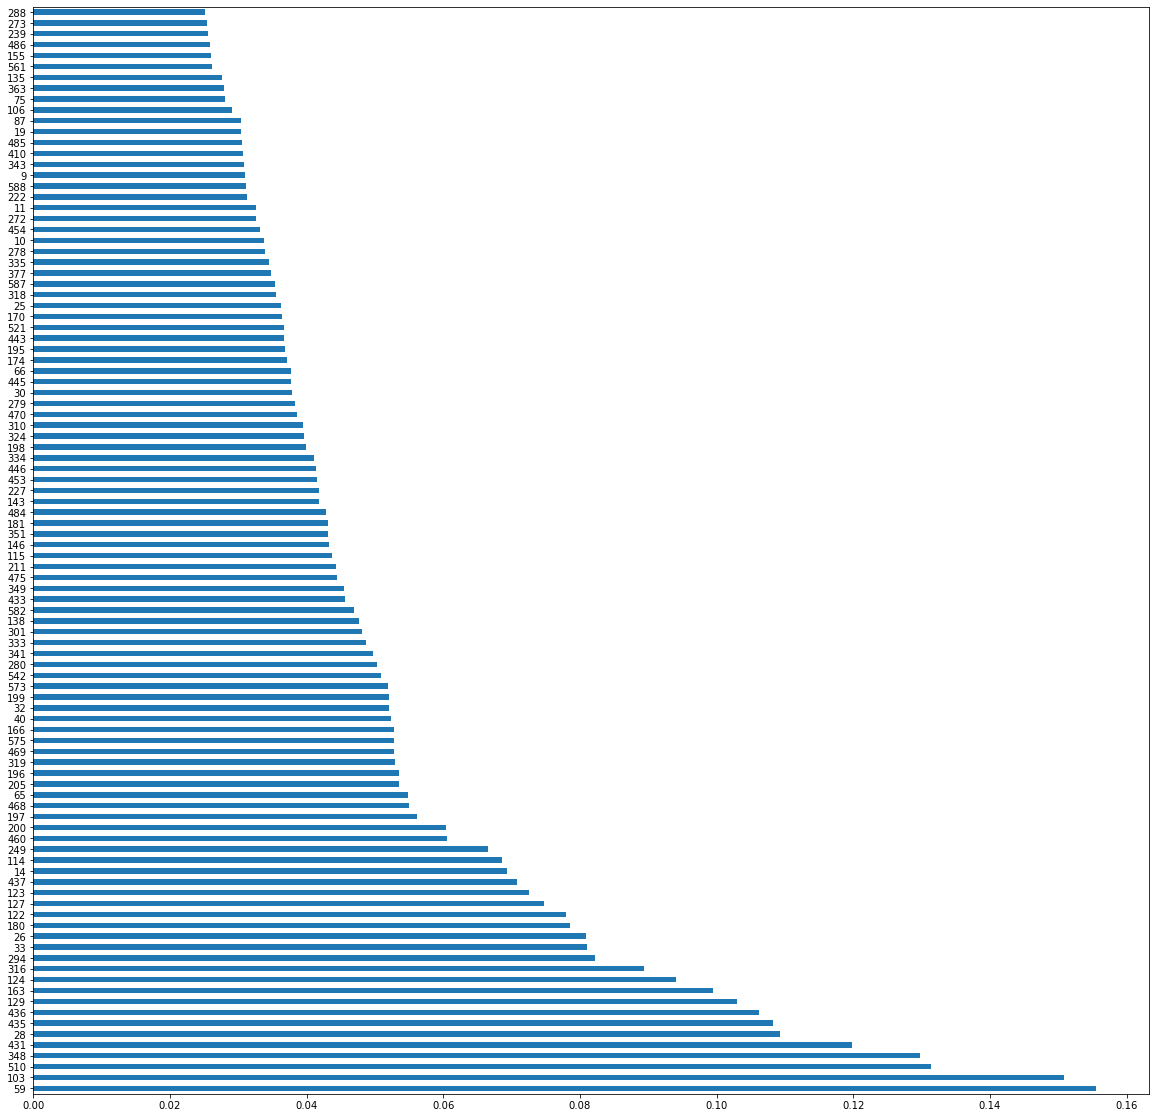

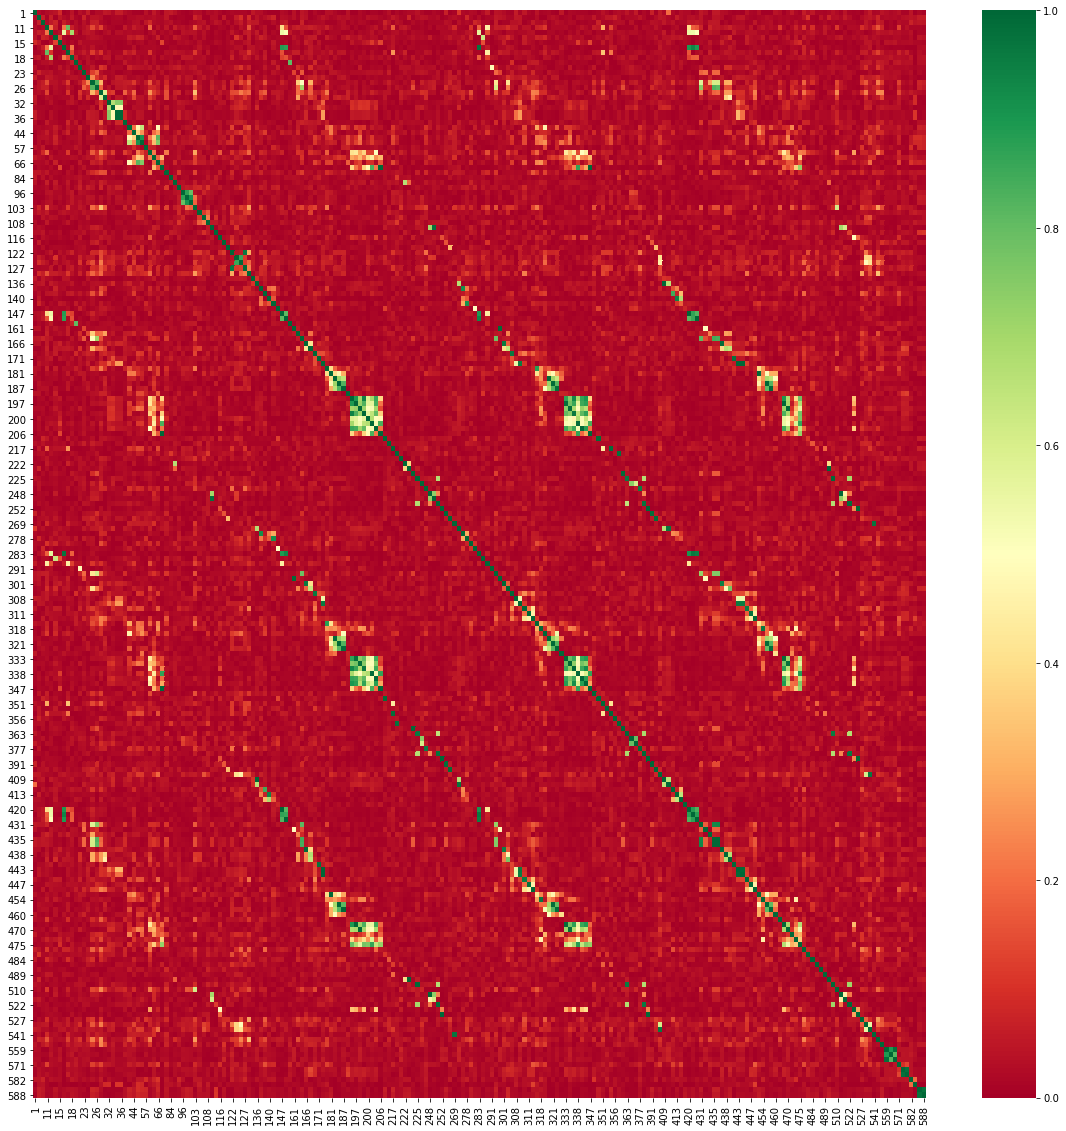

In [74]:
sel_variables_edge = [str(i) for i in variables_edge]
sel_variables_edge.append('Fault')
sel_data_edge = data_prepro.loc[:, sel_variables_edge]

sel_corrmat_edge = abs(sel_data_edge.corr())
correlation_function(sel_corrmat_edge, 'sel_edge')

C:\Users\HANSUNG\.conda\envs\HAR\lib\site-packages\ipykernel_launcher.py:10: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



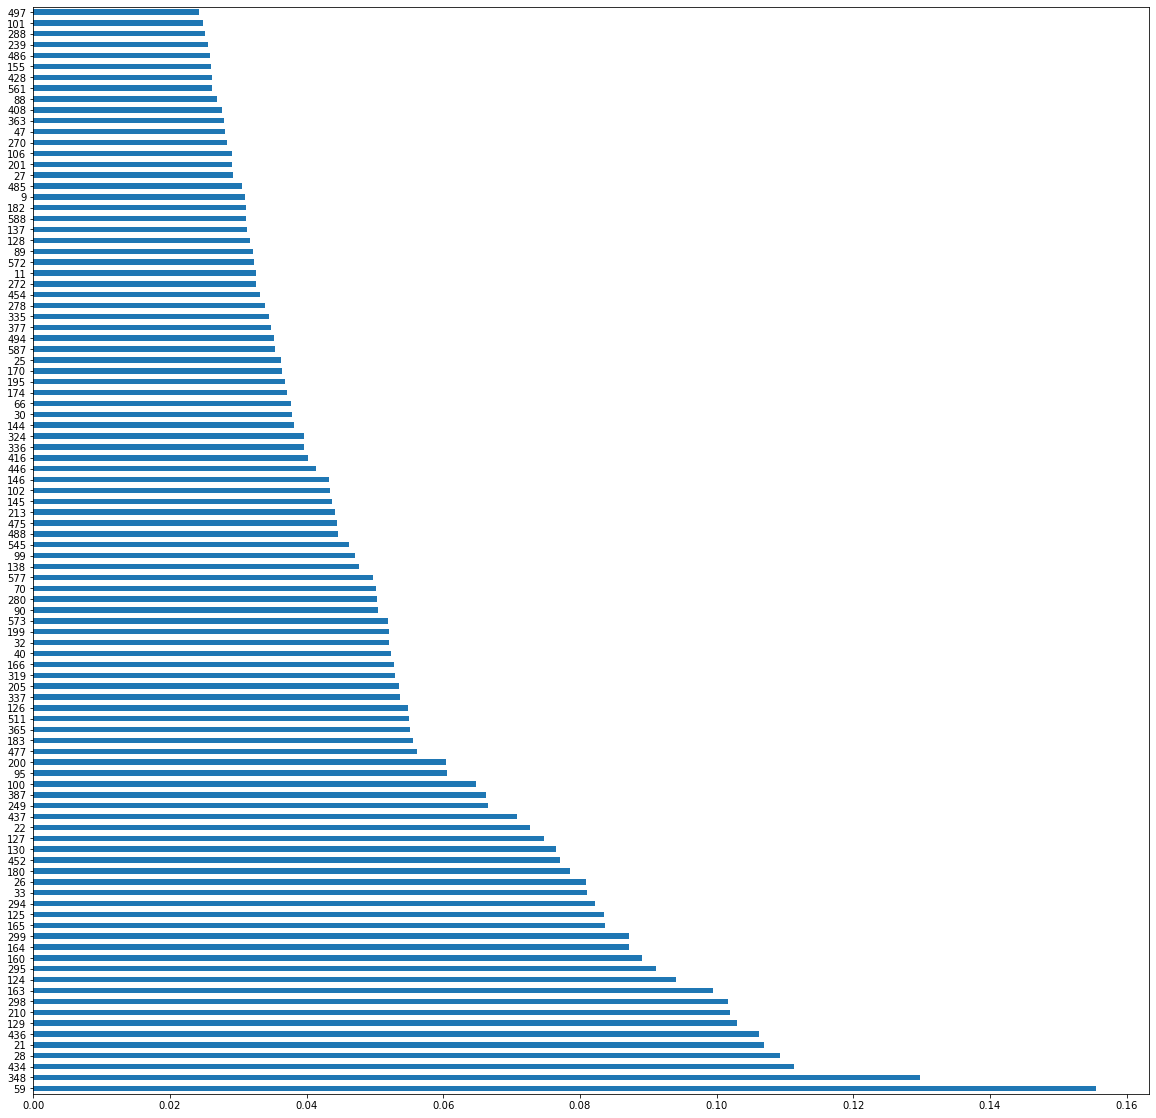

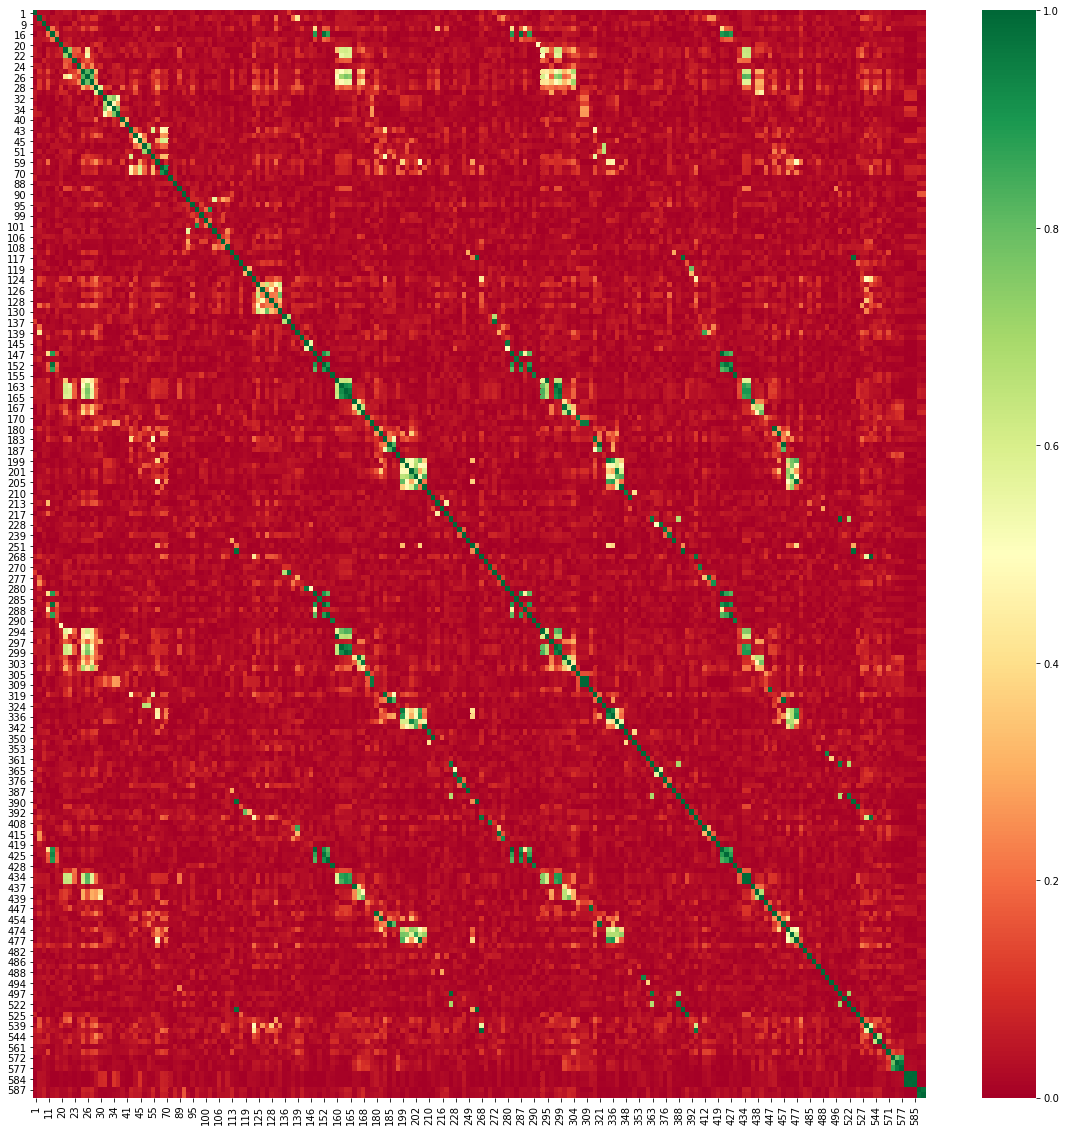

In [76]:
sel_variables_cloud = [str(i) for i in variables_cloud]
sel_variables_cloud.append('Fault')
sel_data_cloud = data_prepro.loc[:, sel_variables_cloud]

sel_corrmat_cloud = abs(sel_data_cloud.corr())
correlation_function(sel_corrmat_cloud, 'sel_cloud')

# Training & Test

In [101]:
def test_model(clf, x, y, title):
    print('Test on {}'.format(title))
    labels = ['Pass', 'Fail']
#     y_pred = clf.predict(x)
    y_pred = clf.predict_classes(x)
    
    # Confusion matrix and classification report
    matrix = confusion_matrix(y, y_pred)
    g=sns.heatmap(matrix,annot=True,cbar=False, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion matrix of {}'.format(title))
    if not load_saved_model:
        plt.savefig('conmatrix-{}.png'.format(title))
    plt.show()
    plt.close()
    
    counts = y.value_counts()
    print(counts)
    
    f = open('test-{}.txt'.format(title), 'w')
    info = 'Scenario : {}\n'.format(title)
    if 'test' in title:
        info += 'Pass/Fail : {}/{}\n'.format(counts[0], counts[1])
    else:
        info += 'Pass : {}\n'.format(counts[0])    
    info += classification_report(y, y_pred, target_names=labels)
    f.write(info)
    print(info)
    

def train_model(x, y, title):
    print('Training')
    clf = Sequential()
    clf.add(Dense(64, input_dim=x.shape[1], activation='relu'))
    clf.add(Dense(32, activation='relu'))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print(clf.summary())
    plot_model(clf, to_file='model_{}.png'.format(title))
    
    clf.fit(x, y, epochs=100)
    
    clf.save('model_{}.h5'.format(title))
    
    return clf

## Model - all features

In [91]:
x_train_sample.shape

(2340, 422)

In [86]:
title = 'all'
if not load_saved_model:
    clf_all = train_model(x_train_sample, y_train_sample, title)
else:
    clf_all = load_model('model_{}.h5'.format(title))

Training
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 64)                27072     
_________________________________________________________________
dense_71 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 33        
Total params: 29,185
Trainable params: 29,185
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
2340/2340 [==============================] - 0s 183us/step - loss: 0.6653 - accuracy: 0.5863
Epoch 2/100
2340/2340 [==============================] - 0s 111us/step - loss: 0.5791 - accuracy: 0.7321
Epoch 3/100
2340/2340 [==============================] - 0s 120us/step - loss: 0.4846 - accuracy: 0.7833
Epoch 4/100
2340/2340 [===========================

2340/2340 [==============================] - 0s 98us/step - loss: 4.1156e-04 - accuracy: 1.0000
Epoch 71/100
2340/2340 [==============================] - 0s 99us/step - loss: 3.9476e-04 - accuracy: 1.0000
Epoch 72/100
2340/2340 [==============================] - 0s 105us/step - loss: 3.7578e-04 - accuracy: 1.0000
Epoch 73/100
2340/2340 [==============================] - 0s 105us/step - loss: 3.5426e-04 - accuracy: 1.0000
Epoch 74/100
2340/2340 [==============================] - 0s 105us/step - loss: 3.5450e-04 - accuracy: 1.0000
Epoch 75/100
2340/2340 [==============================] - 0s 131us/step - loss: 3.2357e-04 - accuracy: 1.0000
Epoch 76/100
2340/2340 [==============================] - 0s 116us/step - loss: 3.0729e-04 - accuracy: 1.0000
Epoch 77/100
2340/2340 [==============================] - 0s 104us/step - loss: 2.8136e-04 - accuracy: 1.0000
Epoch 78/100
2340/2340 [==============================] - 0s 117us/step - loss: 2.7031e-04 - accuracy: 1.0000
Epoch 79/100
2340/2340 [=

Test on train_all


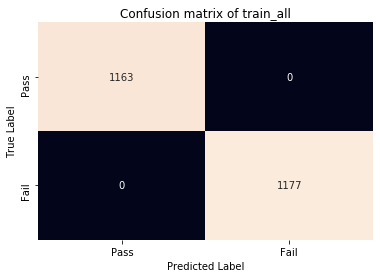

1.0    1177
0.0    1163
Name: Fault, dtype: int64
Scenario : train_all
Pass : 1163
              precision    recall  f1-score   support

        Pass       1.00      1.00      1.00      1163
        Fail       1.00      1.00      1.00      1177

    accuracy                           1.00      2340
   macro avg       1.00      1.00      1.00      2340
weighted avg       1.00      1.00      1.00      2340



In [102]:
test_model(clf_all, x_train_sample, y_train_sample, 'train_all')

Test on test_all


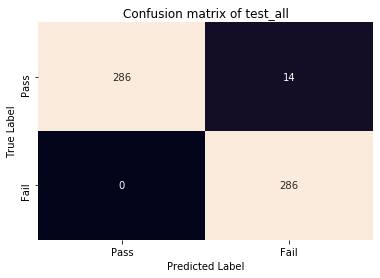

0.0    300
1.0    286
Name: Fault, dtype: int64
Scenario : test_all
Pass/Fail : 300/286
              precision    recall  f1-score   support

        Pass       1.00      0.95      0.98       300
        Fail       0.95      1.00      0.98       286

    accuracy                           0.98       586
   macro avg       0.98      0.98      0.98       586
weighted avg       0.98      0.98      0.98       586



In [103]:
test_model(clf_all, x_test_sample, y_test_sample, 'test_all')

## Model - CLFS edge

In [92]:
x_train_sel_edge = x_train_sample.loc[:, variables_edge]
x_test_sel_edge = x_test_sample.loc[:, variables_edge]
x_train_sel_edge.shape

(2340, 217)

In [90]:
title = 'edge'
if not load_saved_model:
    clf_edge = train_model(x_train_sel_edge, y_train_sample, title)
else:
    clf_edge = load_model('model_{}.h5'.format(title))

Training
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 64)                13952     
_________________________________________________________________
dense_74 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 33        
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
2340/2340 [==============================] - 0s 172us/step - loss: 0.6675 - accuracy: 0.6030
Epoch 2/100
2340/2340 [==============================] - 0s 126us/step - loss: 0.6013 - accuracy: 0.6906
Epoch 3/100
2340/2340 [==============================] - 0s 98us/step - loss: 0.5291 - accuracy: 0.7564
Epoch 4/100
2340/2340 [============================

2340/2340 [==============================] - 0s 97us/step - loss: 6.4722e-04 - accuracy: 1.0000
Epoch 71/100
2340/2340 [==============================] - 0s 100us/step - loss: 6.4073e-04 - accuracy: 1.0000
Epoch 72/100
2340/2340 [==============================] - 0s 97us/step - loss: 9.4185e-04 - accuracy: 1.0000
Epoch 73/100
2340/2340 [==============================] - 0s 96us/step - loss: 5.4118e-04 - accuracy: 1.0000
Epoch 74/100
2340/2340 [==============================] - 0s 97us/step - loss: 4.9457e-04 - accuracy: 1.0000
Epoch 75/100
2340/2340 [==============================] - 0s 97us/step - loss: 4.7394e-04 - accuracy: 1.0000
Epoch 76/100
2340/2340 [==============================] - 0s 103us/step - loss: 4.4405e-04 - accuracy: 1.0000
Epoch 77/100
2340/2340 [==============================] - 0s 98us/step - loss: 4.3765e-04 - accuracy: 1.0000
Epoch 78/100
2340/2340 [==============================] - 0s 101us/step - loss: 4.7104e-04 - accuracy: 1.0000
Epoch 79/100
2340/2340 [=====

Test on train_edge


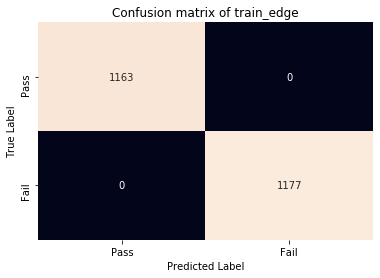

1.0    1177
0.0    1163
Name: Fault, dtype: int64
Scenario : train_edge
Pass : 1163
              precision    recall  f1-score   support

        Pass       1.00      1.00      1.00      1163
        Fail       1.00      1.00      1.00      1177

    accuracy                           1.00      2340
   macro avg       1.00      1.00      1.00      2340
weighted avg       1.00      1.00      1.00      2340



In [104]:
test_model(clf_clfs_edge, x_train_sel_edge, y_train_sample, 'train_edge')

Test on test_edge


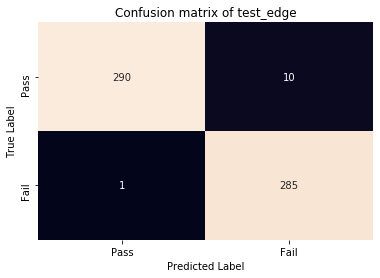

0.0    300
1.0    286
Name: Fault, dtype: int64
Scenario : test_edge
Pass/Fail : 300/286
              precision    recall  f1-score   support

        Pass       1.00      0.97      0.98       300
        Fail       0.97      1.00      0.98       286

    accuracy                           0.98       586
   macro avg       0.98      0.98      0.98       586
weighted avg       0.98      0.98      0.98       586



In [105]:
test_model(clf_clfs_edge, x_test_sel_edge, y_test_sample, 'test_edge')

## Model - CLFS cloud

In [95]:
x_train_sel_cloud = x_train_sample.loc[:, variables_cloud]
x_test_sel_cloud = x_test_sample.loc[:, variables_cloud]
x_train_sel_cloud.shape

(2340, 204)

In [96]:
title = 'cloud'
if not load_saved_model:
    clf_cloud = train_model(x_train_sel_cloud, y_train_sample, title)
else:
    clf_cloud = load_model('model_{}.h5'.format(title))

Training
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 64)                13120     
_________________________________________________________________
dense_77 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 33        
Total params: 15,233
Trainable params: 15,233
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
2340/2340 [==============================] - 0s 169us/step - loss: 0.6621 - accuracy: 0.6201
Epoch 2/100
2340/2340 [==============================] - 0s 95us/step - loss: 0.6000 - accuracy: 0.7068
Epoch 3/100
2340/2340 [==============================] - 0s 146us/step - loss: 0.5356 - accuracy: 0.7427
Epoch 4/100
2340/2340 [============================

2340/2340 [==============================] - 0s 94us/step - loss: 4.6950e-04 - accuracy: 1.0000
Epoch 72/100
2340/2340 [==============================] - 0s 100us/step - loss: 4.2077e-04 - accuracy: 1.0000
Epoch 73/100
2340/2340 [==============================] - 0s 94us/step - loss: 4.1477e-04 - accuracy: 1.0000
Epoch 74/100
2340/2340 [==============================] - 0s 93us/step - loss: 4.0324e-04 - accuracy: 1.0000
Epoch 75/100
2340/2340 [==============================] - 0s 94us/step - loss: 3.6394e-04 - accuracy: 1.0000
Epoch 76/100
2340/2340 [==============================] - 0s 122us/step - loss: 3.6151e-04 - accuracy: 1.0000
Epoch 77/100
2340/2340 [==============================] - 0s 99us/step - loss: 3.2748e-04 - accuracy: 1.0000
Epoch 78/100
2340/2340 [==============================] - 0s 94us/step - loss: 3.0557e-04 - accuracy: 1.0000
Epoch 79/100
2340/2340 [==============================] - 0s 95us/step - loss: 2.9445e-04 - accuracy: 1.0000
Epoch 80/100
2340/2340 [======

Test on train_cloud


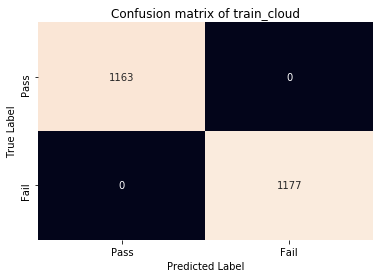

1.0    1177
0.0    1163
Name: Fault, dtype: int64
Scenario : train_cloud
Pass : 1163
              precision    recall  f1-score   support

        Pass       1.00      1.00      1.00      1163
        Fail       1.00      1.00      1.00      1177

    accuracy                           1.00      2340
   macro avg       1.00      1.00      1.00      2340
weighted avg       1.00      1.00      1.00      2340



In [106]:
test_model(clf_clfs_cloud, x_train_sel_cloud, y_train_sample, 'train_cloud')

Test on test_cloud


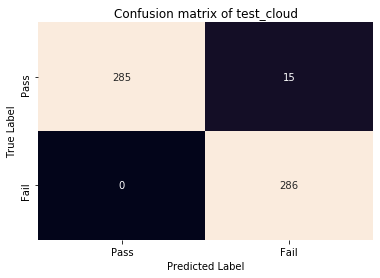

0.0    300
1.0    286
Name: Fault, dtype: int64
Scenario : test_cloud
Pass/Fail : 300/286
              precision    recall  f1-score   support

        Pass       1.00      0.95      0.97       300
        Fail       0.95      1.00      0.97       286

    accuracy                           0.97       586
   macro avg       0.98      0.97      0.97       586
weighted avg       0.98      0.97      0.97       586



In [107]:
test_model(clf_clfs_cloud, x_test_sel_cloud, y_test_sample, 'test_cloud')